# BOW

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from torch.autograd import Variable
from global_parser import parser
from glove import read_glove
from vocabulary import Vocabulary
from split_label import SplitLabel
import matplotlib.pyplot as plt

In [2]:
parser.read("../data/bow.config")

['../data/bow.config']

In [3]:
class BagOfWords(nn.Module):

    def __init__(self, tagset_size, word_embeddings, file_path):
        self.embedding_dim = int(parser['Network Structure']['word_embedding_dim'])
        self.hidden_dim = int(self.embedding_dim*2/3)
        # self.hidden_dim = 128

        super(BagOfWords, self).__init__()

        self.word_embeddings = word_embeddings

        self.hidden2tag = nn.Linear(self.embedding_dim, self.hidden_dim)

        self.activation_function1 = nn.Tanh()

        self.hidden3tag = nn.Linear(self.hidden_dim, tagset_size)

    def forward(self, sentence):
        sentence_vector = self.word_embeddings(sentence)
        sentence_vector = torch.mean(sentence_vector, dim=0)
        tag_space = self.hidden2tag(sentence_vector)

        tag_space = self.activation_function1(tag_space)

        tag_space = self.hidden3tag(tag_space)

        tag_scores = F.log_softmax(tag_space, dim = -1)

        return tag_scores.unsqueeze(0)

In [5]:
# train
lrs = np.arange(0.01, 0.1, 0.01)
accuracy_list = []
f1_list = []
for lr in lrs:
    pretrained = eval(parser['Options for model']['pretrained'])
    freeze = eval(parser['Options for model']['freeze'])
    train_path = parser['Paths To Datasets And Evaluation']['path_train']
    word_dim = parser['Network Structure']['word_embedding_dim']
#     learning_rate = float(parser['Hyperparameters']['lr_param'])
    model_type = parser['Options for model']['model']
    epoch_number = int(parser['Model Settings']['epoch'])
    if pretrained:
        if freeze:
            print("Training pretrained and freeze", model_type, "model...")
        else:
            print("Training pretrained and fine-tuning", model_type, "model...")
        print()
        glove_path = parser['Using pre-trained Embeddings']['path_pre_emb']
        vec = read_glove(glove_path)
        voca = Vocabulary("train", word_dim)
        voca.set_word_vector(vec)
        voca.from_word2vect_word2ind()
        voca.from_word2vect_wordEmbeddings(freeze)
        word_emb = voca.get_word_embeddings()
    else:
        print("Training random", model_type, "model...")
        print()
        voca = Vocabulary("train", word_dim)
        voca.setup('../data/train.txt')
        word_emb = voca.get_word_embeddings()
    features,labels = SplitLabel(train_path).generate_sentences()

    tag_to_ix = {}
    id = 0
    for l in labels:
        if l not in tag_to_ix.keys():
            tag_to_ix[l] = id
            id += 1

    model = BagOfWords(len(tag_to_ix), word_emb, "../data/bow.config")

    loss_function = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    #optimizer = optim.Adam(model.parameters(), lr=0.05)
    #optimizer = torch.optim.Adam(model.parameters(), lr= 0.01)

    for epoch in range(epoch_number):  # again, normally you would NOT do 300 epochs, it is toy data
        for sentence, tags in zip(features, labels):
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()

            # Step 2. Get our inputs ready for the network, that is, turn them into
            # Tensors of word indices.
            sentence_in = voca.get_sentence_ind(sentence,"Bow")
            targets = torch.tensor([tag_to_ix[tags]],dtype=torch.long)

            # Step 3. Run our forward pass.
            tag_scores = model.forward(sentence_in)
            #
            # Step 4. Compute the loss, gradients, and update the parameters by
            #  calling optimizer.step()
            loss = loss_function(tag_scores, targets)

            loss.backward()
            optimizer.step()

        print("Epoch", epoch)
        with torch.no_grad():
            y_true = []
            y_pred = []
            most_error_label = {}
            for sentence, tags in zip(features,labels):
                sentence_in = voca.get_sentence_ind(sentence,"Bow")
                tag_scores = model.forward(sentence_in)

                ind = torch.argmax(tag_scores)

                y_pred.append(ind)
                y_true.append(tag_to_ix[tags])

                if tag_to_ix[tags] != ind:
                    if tags not in most_error_label.keys():
                        most_error_label[tags] = 1
                    else:
                        most_error_label[tags] += 1

            most_error_label = sorted(most_error_label.items(), key=lambda item: item[1], reverse=True)[:3]

            print("Accuracy", accuracy_score(y_true,y_pred))
            print("F1-score", f1_score(y_true,y_pred,average='macro'))
            # print("Confusion_matrix \n", confusion_matrix(y_true,y_pred))
            # print("First three most frequent misclassifed label:",most_error_label)
            print()

    torch.save(model, parser['Options for model']['model_save_path'])

    tag2index_filepath = parser['Options for model']['tag2index_save_path']
    tag2index_file = open(tag2index_filepath, "wb")
    pickle.dump(tag_to_ix, tag2index_file)
    tag2index_file.close()

    voca_filepath = parser['Options for model']['voca_save_path']
    voca_file = open(voca_filepath, "wb")
    pickle.dump(voca, voca_file)
    voca_file.close()
    
    
    pretrained = eval(parser['Options for model']['pretrained'])
    model_type = parser['Options for model']['model']
    if pretrained:
        freeze = eval(parser['Options for model']['freeze'])
        if freeze:
            print("Testing pretrained and freeze", model_type, "model...")
        else:
            print("Testing pretrained and fine-tuning", model_type, "model...")
    else:
        print("Testing random", model_type, "model...")
    print()

    output_file = parser['Evaluation']['path_eval_result']
    model_path = parser['Options for model']['model_save_path']
    model = torch.load(model_path)
    model.to('cpu')
    tag2index_path = parser['Options for model']['tag2index_save_path']
    tag2index_file = open(tag2index_path, "rb")
    tag_to_ix = pickle.load(tag2index_file)

    voca_filepath = parser['Options for model']['voca_save_path']
    voca_file = open(voca_filepath, "rb")
    voca = pickle.load(voca_file)

    test_path = parser['Paths To Datasets And Evaluation']['path_test']
    features, labels = SplitLabel(test_path).generate_sentences()

    with torch.no_grad():
        y_true = []
        y_pred = []
        most_error_label = {}
        with open(output_file, 'w') as f:
            for sentence, tags in zip(features,labels):
                sentence_in = voca.get_sentence_ind(sentence,"Bow")
                tag_scores = model.forward(sentence_in)
                ind = torch.argmax(tag_scores)

                predicted_label = list(tag_to_ix.keys())[list(tag_to_ix.values()).index(ind)]
                f.write(str(predicted_label) + "\n")
                y_pred.append(ind)
                y_true.append(tag_to_ix[tags])

                if tag_to_ix[tags] != ind:
                    if tags not in most_error_label.keys():
                        most_error_label[tags] = 1
                    else:
                        most_error_label[tags] += 1

            most_error_label = sorted(most_error_label.items(), key=lambda item: item[1], reverse=True)[:3]
            accuracy = accuracy_score(y_true,y_pred)
            f.write("Overall Accuracy of " + str(model_type) + " model:" + str(accuracy))
            f.close()

        print("Accuracy", accuracy)
        f1_score_obtained = f1_score(y_true,y_pred,average='macro')
        print("F1-score", f1_score_obtained)
        print("Confusion_matrix \n", confusion_matrix(y_true,y_pred))
        print("First three most frequent misclassifed label:",most_error_label)
        accuracy_list.append(accuracy)
        f1_list.append(f1_score_obtained)
    

Training pretrained and freeze bow model...

Epoch 0
Accuracy 0.41194455768446797
F1-score 0.07257549015507574

Epoch 1
Accuracy 0.5073379535262943
F1-score 0.1414976660175663

Epoch 2
Accuracy 0.5725642070933551
F1-score 0.21809934506939363

Epoch 3
Accuracy 0.616184264166327
F1-score 0.2744193874475678

Epoch 4
Accuracy 0.6553200163065634
F1-score 0.326590815424479

Epoch 5
Accuracy 0.6789645332246229
F1-score 0.3840057494497271

Epoch 6
Accuracy 0.7030167142274766
F1-score 0.43250549488611506

Epoch 7
Accuracy 0.7197309417040358
F1-score 0.4684016334030591

Epoch 8
Accuracy 0.7344068487566245
F1-score 0.5065286970156739

Epoch 9
Accuracy 0.7480635955972279
F1-score 0.5470732428999879

Testing pretrained and freeze bow model...

Accuracy 0.718
F1-score 0.43358676837543864
Confusion_matrix 
 [[ 0  0  0 ...  0  0  0]
 [ 0  7  0 ...  0  0  0]
 [ 1  0 50 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  2  0 ...  0  1  0]
 [ 0  0  0 ...  0  0  0]]
First three most frequent misclassifed l

Epoch 0
Accuracy 0.5487158581328985
F1-score 0.334789366348568

Epoch 1
Accuracy 0.5713412148389727
F1-score 0.4605647939225299

Epoch 2
Accuracy 0.5939665715450468
F1-score 0.5293957835465974

Epoch 3
Accuracy 0.566245413779046
F1-score 0.5365797500356446

Epoch 4
Accuracy 0.5945780676722381
F1-score 0.5661894227903363

Epoch 5
Accuracy 0.6084386465552385
F1-score 0.5886873577213109

Epoch 6
Accuracy 0.6512433754586221
F1-score 0.6487579480872943

Epoch 7
Accuracy 0.6121076233183856
F1-score 0.5979591662364803

Epoch 8
Accuracy 0.6545046881369752
F1-score 0.5953115793508017

Epoch 9
Accuracy 0.6347329800244599
F1-score 0.6307853427919423

Testing pretrained and freeze bow model...

Accuracy 0.596
F1-score 0.4225102417694252
Confusion_matrix 
 [[ 0  0  0 ...  0  0  0]
 [ 0  6  0 ...  0  0  0]
 [ 1  0 45 ...  0  0  0]
 ...
 [ 0  0  0 ...  2  0  0]
 [ 0  0  0 ...  0  3  0]
 [ 0  0  0 ...  0  0  1]]
First three most frequent misclassifed label: [('DESC:def', 38), ('LOC:other', 14), ('LOC:

In [6]:
print("accuracies among all learning rates:", accuracy_list)
print("accuracies among all learning rates:", f1_list)
lr_list = lrs.tolist()

argmax_accu = accuracy_list.index(max(accuracy_list))
argmax_f1 = f1_list.index(max(f1_list))
ps_x_accu = lr_list[argmax_accu]
ps_y_accu = accuracy_list[argmax_accu]

ps_x_f1 = lr_list[argmax_f1]
ps_y_f1 = f1_list[argmax_f1]

print("the optimum one is ", ps_x_accu)

accuracies among all learning rates: [0.718, 0.742, 0.72, 0.706, 0.664, 0.602, 0.598, 0.572, 0.596]
accuracies among all learning rates: [0.43358676837543864, 0.5947620249836307, 0.5283912063882726, 0.5331940228517213, 0.4765002698861868, 0.439850843312916, 0.41425758390604195, 0.4161706073306184, 0.4225102417694252]
the optimum one is  0.02


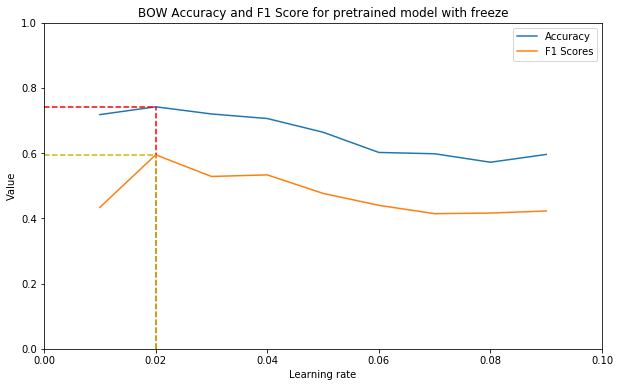

In [7]:

plt.figure(figsize=(10,6))
plt.xlim([0, 0.1])
plt.ylim([0, 1])
plt.plot(lr_list,accuracy_list,label='Accuracy')
plt.plot(lr_list,f1_list,label='F1 Scores')
plt.plot([0, ps_x_accu],[ps_y_accu,ps_y_accu], c='r', linestyle = '--')
plt.plot([ps_x_accu, ps_x_accu],[0,ps_y_accu], c='r', linestyle = '--')



plt.plot([0, ps_x_f1],[ps_y_f1,ps_y_f1], c='y', linestyle = '--')
plt.plot([ps_x_f1, ps_x_f1],[0,ps_y_f1], c='y', linestyle = '--')

ps_coord_str_accu = "max: " + str((lr_list[argmax_accu],round(accuracy_list[argmax_accu],3)))
plt.title("BOW Accuracy and F1 Score for pretrained model with freeze")
plt.xlabel('Learning rate')
plt.ylabel('Value')
plt.legend()
# plt.show()
plt.savefig("../visualization/out_bow_pre_freeze.jpg")

# BiLSTM

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from global_parser import parser
from glove import read_glove
from split_label import SplitLabel
from vocabulary import Vocabulary
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
parser.read("../data/bilstm.config")

In [ ]:
class BiLSTMTagger(nn.Module):

    def __init__(self, tagset_size, file_path, word_embeddings):
        self.embedding_dim = int(parser['Network Structure']['word_embedding_dim'])
        self.batch_size = int(parser['Network Structure']['batch_size'])

        super(BiLSTMTagger, self).__init__()
        self.hidden_dim = int(parser['Network Structure']['hidden_dim'])

        self.bilstm = nn.LSTM(self.embedding_dim, self.hidden_dim, bidirectional=True)
        self.word_embeddings = word_embeddings
        self.hidden2tag = nn.Linear(self.hidden_dim * 2, tagset_size)

    def forward(self, sentence_in):
        embeds = self.word_embeddings(sentence_in)
        bilstm_out, (h_n, c_n) = self.bilstm(embeds.view(len(embeds), 1, -1))

        out = torch.hstack((h_n[-2, :, :], h_n[-1, :, :]))
        tag_space = self.hidden2tag(out)

        tag_scores = F.log_softmax(tag_space, dim = -1)

        return tag_scores

In [ ]:
# pretrained = eval(parser['Options for model']['pretrained'])
# freeze = eval(parser['Options for model']['freeze'])
# train_path = parser['Paths To Datasets And Evaluation']['path_train']
# word_dim = parser['Network Structure']['word_embedding_dim']
# # learning_rate = float(parser['Hyperparameters']['lr_param'])
# model_type = parser['Options for model']['model']
# epoch_number = int(parser['Model Settings']['epoch'])
# if pretrained:
#     if freeze:
#         print("Training pretrained and freeze", model_type, "model...")
#     else:
#         print("Training pretrained and fine-tuning", model_type, "model...")
#     print()
#     glove_path = parser['Using pre-trained Embeddings']['path_pre_emb']
#     vec = read_glove(glove_path)
#     voca = Vocabulary("train", word_dim)
#     voca.set_word_vector(vec)
#     voca.from_word2vect_word2ind()
#     voca.from_word2vect_wordEmbeddings(freeze)
#     word_emb = voca.get_word_embeddings()

# else:
#     print("Training random", model_type, "model...")
#     print()
#     voca = Vocabulary("train", word_dim)
#     voca.setup('../data/train.txt')
#     word_emb = voca.get_word_embeddings()
# features,labels = SplitLabel(train_path).generate_sentences()
# tag_to_ix = {}
# id = 0
# for l in labels:
#     if l not in tag_to_ix.keys():
#         tag_to_ix[l] = id
#         id += 1
# model = BiLSTMTagger(len(tag_to_ix), '../data/bilstm.config', word_emb)

# loss_function = nn.NLLLoss()



accuracy_list = []
f1_list = []
# lrs = np.arange(0.01, 0.1, 0.01)
lrs = np.array([ 0.01*1.58**j for j in range(0,11)])
# lr_list = lrs.tolist()
for lr in lrs:
    pretrained = eval(parser['Options for model']['pretrained'])
    freeze = eval(parser['Options for model']['freeze'])
    train_path = parser['Paths To Datasets And Evaluation']['path_train']
    word_dim = parser['Network Structure']['word_embedding_dim']
    # learning_rate = float(parser['Hyperparameters']['lr_param'])
    model_type = parser['Options for model']['model']
    epoch_number = int(parser['Model Settings']['epoch'])
    if pretrained:
        if freeze:
            print("Training pretrained and freeze", model_type, "model...")
        else:
            print("Training pretrained and fine-tuning", model_type, "model...")
        print()
        glove_path = parser['Using pre-trained Embeddings']['path_pre_emb']
        vec = read_glove(glove_path)
        voca = Vocabulary("train", word_dim)
        voca.set_word_vector(vec)
        voca.from_word2vect_word2ind()
        voca.from_word2vect_wordEmbeddings(freeze)
        word_emb = voca.get_word_embeddings()

    else:
        print("Training random", model_type, "model...")
        print()
        voca = Vocabulary("train", word_dim)
        voca.setup('../data/train.txt')
        word_emb = voca.get_word_embeddings()
    features,labels = SplitLabel(train_path).generate_sentences()
    tag_to_ix = {}
    id = 0
    for l in labels:
        if l not in tag_to_ix.keys():
            tag_to_ix[l] = id
            id += 1
    model = BiLSTMTagger(len(tag_to_ix), '../data/bilstm.config', word_emb)

    loss_function = nn.NLLLoss()
    
    optimizer = optim.SGD(model.parameters(), lr=lr)
    #optimizer = optim.Adam(model.parameters(), lr=0.05)
    #optimizer = torch.optim.Adam(model.parameters(), lr= 0.01)

    for epoch in range(epoch_number):  # again, normally you would NOT do 300 epochs, it is toy data
        for sentence, tags in zip(features, labels):
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()

            # Step 2. Get our inputs ready for the network, that is, turn them into
            # Tensors of word indices.
            sentence_in = voca.get_sentence_ind(sentence,"Bilstm")
            targets = torch.tensor([tag_to_ix[tags]],dtype=torch.long)

            # Step 3. Run our forward pass.
            tag_scores = model.forward(sentence_in)
            #
            # Step 4. Compute the loss, gradients, and update the parameters by
            #  calling optimizer.step()
            loss = loss_function(tag_scores, targets)

            loss.backward()
            optimizer.step()

        print("Epoch", epoch)
        with torch.no_grad():
            y_true = []
            y_pred = []
            most_error_label = {}
            for sentence, tags in zip(features,labels):
                sentence_in = voca.get_sentence_ind(sentence,"Bilstm")
                tag_scores = model.forward(sentence_in)

                ind = torch.argmax(tag_scores)

                y_pred.append(ind)
                y_true.append(tag_to_ix[tags])

                if tag_to_ix[tags] != ind:
                    if tags not in most_error_label.keys():
                        most_error_label[tags] = 1
                    else:
                        most_error_label[tags] += 1


    test_path = parser['Paths To Datasets And Evaluation']['path_dev']
    features, labels = SplitLabel(test_path).generate_sentences()

    with torch.no_grad():
        y_true = []
        y_pred = []
        most_error_label = {}
        for sentence, tags in zip(features,labels):
            sentence_in = voca.get_sentence_ind(sentence,"Bilstm")
            tag_scores = model.forward(sentence_in)
            ind = torch.argmax(tag_scores)
            y_pred.append(ind)
            y_true.append(tag_to_ix[tags])

            if tag_to_ix[tags] != ind:
                if tags not in most_error_label.keys():
                    most_error_label[tags] = 1
                else:
                    most_error_label[tags] += 1

        most_error_label = sorted(most_error_label.items(), key=lambda item: item[1], reverse=True)[:3]
        # print("Total number of labels:", len(most_error_label)) ## 33
        accuracy = accuracy_score(y_true,y_pred)
        accuracy_list.append(accuracy)
        f1 = f1_score(y_true,y_pred,average='macro')
        f1_list.append(f1)
        print("Accuracy", accuracy)
        print("F1-score", f1)

In [ ]:
# print("accuracies among all learning rates:", accuracy_list)
# print("accuracies among all learning rates:", f1_list)
# lr_list = lrs.tolist()

# argmax_accu = accuracy_list.index(max(accuracy_list))
# argmax_f1 = f1_list.index(max(f1_list))
# ps_x_accu = lr_list[argmax_accu]
# ps_y_accu = accuracy_list[argmax_accu]

# ps_x_f1 = lr_list[argmax_f1]
# ps_y_f1 = f1_list[argmax_f1]

# print("the optimum one is ", ps_x_accu)

In [ ]:
print("accuracies among all learning rates:", accuracy_list)
print("accuracies among all learning rates:", f1_list)
lr_list = lrs.tolist()
#index_pos = len(list_of_elems) - list_of_elems[::-1].index(elem) - 1
argmax_accu = len(accuracy_list) - accuracy_list[::-1].index(max(accuracy_list)) -1
argmax_f1 = len(f1_list) - f1_list[::-1].index(max(f1_list)) -1
ps_x_accu = lr_list[argmax_accu]
ps_y_accu = accuracy_list[argmax_accu]

ps_x_f1 = lr_list[argmax_f1]
ps_y_f1 = f1_list[argmax_f1]

print("the optimum one is ", ps_x_accu)

In [ ]:
plt.figure(figsize=(10,6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot(lr_list,accuracy_list,label='Accuracy')
plt.plot(lr_list,f1_list,label='F1 Scores')
plt.plot([0, ps_x_accu],[ps_y_accu,ps_y_accu], c='r', linestyle = '--')
plt.plot([ps_x_accu, ps_x_accu],[0,ps_y_accu], c='r', linestyle = '--')



plt.plot([0, ps_x_f1],[ps_y_f1,ps_y_f1], c='y', linestyle = '--')
plt.plot([ps_x_f1, ps_x_f1],[0,ps_y_f1], c='y', linestyle = '--')

ps_coord_str_accu = "max: " + str((lr_list[argmax_accu],round(accuracy_list[argmax_accu],3)))
plt.title("BiLSTM Accuracy and F1 Score for pretrained model with fine-tuning")
plt.xlabel('Learning rate')
plt.ylabel('Value')
plt.legend()
# plt.show()
plt.savefig("../visualization/out_bilstm_pre_fine1.jpg")

In [ ]:
# plt.figure(figsize=(10,6))
# plt.plot(*zip(*accuracy_store),label='Accuracy')
# plt.plot(*zip(*f1_store),label='F1 Scores')
# plt.title("BiLSTM Accuracy and F1 Score for ")
# plt.xlabel('Learning rate')
# plt.ylabel('Value')
# plt.legend()
# # plt.show()
# plt.savefig("out_bilstm_rand.jpg")